# Sendai vs Endo

Working out an EM algorithm to estimate fraction of exogenous transcripts per barcode + simulations to verify. 

Working version in `iterative_bc_endo_exo_cts.py`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
SCHEMA = ['chr', 'start', 'end', 'bc', '-', 'strand']

In [3]:
endo_only = pd.read_csv("./out/OCT4/iPSC.bed", sep='\t',
                       names=SCHEMA)
endo_only.head()

,chr,start,end,bc,-,strand
0,chr6,31164336,31164423,AGCGCTGAGCCAAGCA,255,-
1,chr6,31164336,31164413,CGGTCAGGTAGTGGCA,255,-
2,chr6,31164336,31164396,ATCGGATTCATTGAGC,255,-
3,chr6,31164336,31164420,AGTACTGCATGAAGGC,255,-
4,chr6,31164336,31164420,AGAACCTCAGAGGTAC,255,-


In [4]:
exo_only = pd.read_csv("./out/OCT4/D2.bed", sep='\t',
                       names=SCHEMA)
exo_only.head()

,chr,start,end,bc,-,strand
0,chr6,31164344,31164494,TCATACTGTGGGAGAG,255,-
1,chr6,31164357,31164507,CTGTACCAGTCCCGGT,255,-
2,chr6,31164363,31164511,GATCATGAGTTAACGA,255,-
3,chr6,31164369,31164519,TCAAGCAAGAGAGTTT,255,-
4,chr6,31164378,31164528,GAGCCTGTCACCACAA,255,-


In [6]:
START_OR_END = 'end' # 'start' if gene orientation + else 'end' [5']

In [7]:
ST = min(min(exo_only[START_OR_END]), min(endo_only[START_OR_END]))
END = max(max(exo_only[START_OR_END]), max(endo_only[START_OR_END]))+1 #+ 1000

ST, END

(31164376, 31170683)

In [8]:
END-ST

6307

In [9]:
endo_vec = np.array([0]*(END-ST))
exo_vec = np.array([0]*(END-ST))

vals, cts = np.unique(endo_only[START_OR_END], return_counts=True)
endo_vec[vals-ST] = cts

vals, cts = np.unique(exo_only[START_OR_END], return_counts=True)
exo_vec[vals-ST] = cts
# for _, x in endo_only.iterrows():
#     endo_vec[x['start']-ST] += 1
    
# for _, x in exo_only.iterrows():
#     exo_vec[x['start']-ST] += 1

norm_endo_vec = endo_vec+1
norm_endo_vec = norm_endo_vec/sum(norm_endo_vec)

norm_exo_vec = exo_vec+1
norm_exo_vec = norm_exo_vec/sum(norm_exo_vec)

In [10]:
exo_frac_vector = norm_exo_vec/(norm_exo_vec + norm_endo_vec)

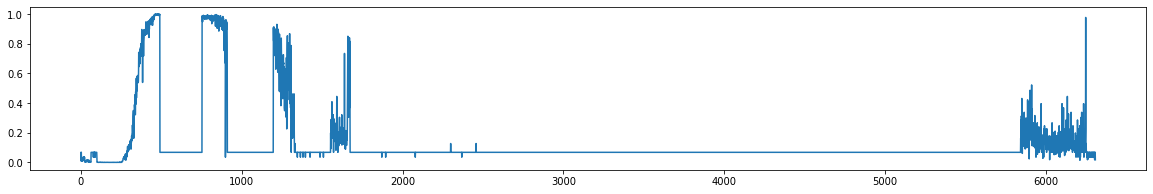

In [11]:
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(exo_frac_vector)

## Iterative

In [12]:
def iterative_frac_exo(df, start_or_end='start', num_iter=10):    
    df = df.copy()
    bc2idx = {x:i for i,x in enumerate(set(df['bc']))}
    idx2bc = {idx:bc for bc,idx in bc2idx.items()}
    df['bc_idx'] = [bc2idx[x] for x in df['bc']]
    
    # make barcode x position counts matrix
    coord_bc_ct = df.groupby([start_or_end, 'bc_idx']).size().reset_index(name='counts')

    bc_cts_mat = np.zeros((len(bc2idx), END-ST))
    bc_cts_mat[coord_bc_ct['bc_idx'], coord_bc_ct[start_or_end] - ST] = coord_bc_ct['counts']

    # intial guess 1:1
    exo_frac_estimate = np.array([0.5]*len(bc2idx))

    per_bc_cts = bc_cts_mat.sum(-1)

    for _ in range(num_iter):
        cur_exo_prob = np.outer(exo_frac_estimate, norm_exo_vec)
        cur_endo_prob = np.outer((1-exo_frac_estimate), norm_endo_vec)

        per_pos_frac_exo = cur_exo_prob/(cur_exo_prob + cur_endo_prob)
        
        # update estimate
        exo_frac_estimate = (per_pos_frac_exo * bc_cts_mat).sum(-1)/per_bc_cts

    exo_cts = exo_frac_estimate * per_bc_cts
    endo_cts = per_bc_cts - exo_cts
    bcs = [idx2bc[i] for i in range(len(idx2bc))]
    
    bc2exo = {x:exo_frac_estimate[i] for i,x in enumerate(bcs)}
    
    return bc2exo

In [13]:
cur_samp = pd.read_csv("./out/OCT4/D14.bed", sep='\t', names=SCHEMA)
cur_samp.head()

,chr,start,end,bc,-,strand
0,chr6,31164336,31164469,CTGGCAGTCTTTCCAA,255,-
1,chr6,31164336,31164482,GTCTCACTCTCGTGAA,255,-
2,chr6,31164336,31164483,GGTGTTAAGGTAGTCG,255,-
3,chr6,31164336,31164469,CATCCACTCGTTCCCA,255,-
4,chr6,31164336,31164480,AAAGAACTCATTGCCC,255,-


In [14]:
exo_frac = list(iterative_frac_exo(cur_samp, start_or_end=START_OR_END).values())

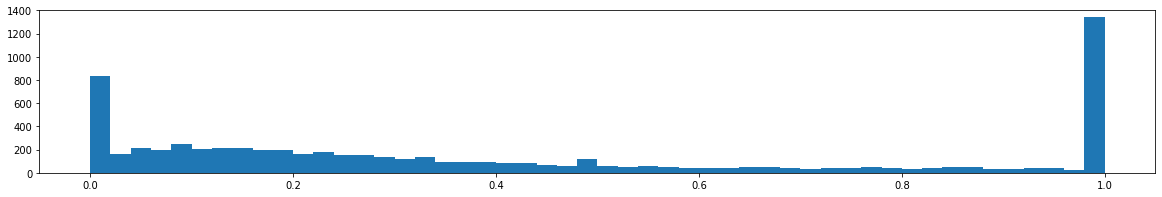

In [15]:
plt.rcParams["figure.figsize"] = (20,3)

plt.hist(exo_frac, bins=50)
plt.show()

## Simulation

Simulation check to see if the recovered frac is correct.

In [16]:
NSAMP=20 # per simulated barcode
PER_FRAC=200 # per fraction (i.e. NSAMP+1)

In [17]:
sim_bcs = []
sim_starts = []
bcs_to_frac = {}

i = 0
for f in range(NSAMP+1):
    for _ in range(PER_FRAC):
        bcs_to_frac[i] = f/NSAMP
              
        exo_starts = np.random.choice(range(len(norm_exo_vec)), f, p=norm_exo_vec)
        endo_starts = np.random.choice(range(len(norm_endo_vec)), NSAMP-f, p=norm_endo_vec)
        
        sim_bcs += [i]*NSAMP
        sim_starts += list(endo_starts + ST) + list(exo_starts + ST)
        
        i+=1

In [18]:
sim_df = pd.DataFrame({START_OR_END:sim_starts, 'bc':sim_bcs})
sim_df.sample(10)

,end,bc
66097,31164863,3304
74352,31165166,3717
44749,31166779,2237
12371,31164730,618
15253,31164599,762
59530,31164742,2976
48373,31164855,2418
17799,31164824,889
13656,31164481,682
53627,31164860,2681


In [19]:
sim_estimate_exo = iterative_frac_exo(sim_df, start_or_end=START_OR_END)

[]

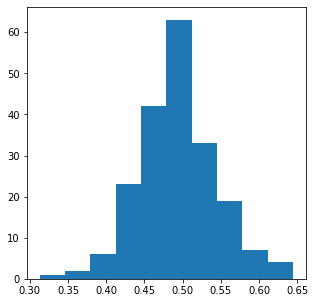

In [20]:
plt.rcParams["figure.figsize"] = (5,5)

fixed_frac_estimate = [sim_estimate_exo[bc] for bc,frac in bcs_to_frac.items() if frac==.5]
plt.hist(fixed_frac_estimate)
plt.plot()

In [21]:
np.mean(fixed_frac_estimate), np.median(fixed_frac_estimate), np.std(fixed_frac_estimate)

(0.4925934321630374, 0.4881644649037379, 0.05123574692467782)

Text(0, 0.5, 'Estimated')

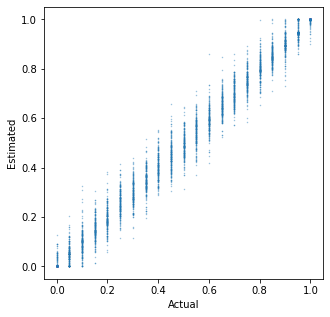

In [22]:
plt.rcParams["figure.figsize"] = (5,5)

plt.scatter([x for i,x in bcs_to_frac.items()], [sim_estimate_exo[x] for x in bcs_to_frac], s=.2, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Estimated")

More noise arises from stochasticity in scRNA sampling transcripts from a cell which would increase error even more.